# Breast Cancer Data Analysis using RF and SVM

### Data Cleaning  - step1(naming/change datatype)

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import graphviz

Breast_cancer = pd.read_csv('breast-cancer-wisconsin.csv')

# Class 2 for benigh, Class 4 for malignant
Breast_cancer.columns = ['id', 
                         'Clump_Thickness', 
                         'Uniformity_of_Cell_Size',
                         'Uniformity_of_Cell_Shape', 
                         'Marginal_Adhesion',
                         'Single_Epithelial_Cell_Size', 
                         'Bare_Nuclei',
                         'Bland_Chromatin',
                         'Normal_Nucleoli',
                         'Mitoses', 
                         'Class']

#X as the independent variable, and Y as dependent variable
Breast_cancer.drop('id',axis=1, inplace = True)
X = Breast_cancer.iloc[: , :-1]
y = Breast_cancer.iloc[: , [-1]]
# Bare_Nucle colum has '?' value at 22th row, making the column dtype 'objest'. Thus i replaced it with -9999(outlier value) 
# and change column dtype to integer using pd.to_numeric
print(X.info())

# based on info, we can find out there is something wrong with 'Bare_Nuclei' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 9 columns):
Clump_Thickness                698 non-null int64
Uniformity_of_Cell_Size        698 non-null int64
Uniformity_of_Cell_Shape       698 non-null int64
Marginal_Adhesion              698 non-null int64
Single_Epithelial_Cell_Size    698 non-null int64
Bare_Nuclei                    698 non-null object
Bland_Chromatin                698 non-null int64
Normal_Nucleoli                698 non-null int64
Mitoses                        698 non-null int64
dtypes: int64(8), object(1)
memory usage: 49.2+ KB
None


### Data Cleaning - step2(check and remove invalid data)

#### Error shows that we have'?' on the 22th row

In [75]:
X['Bare_Nuclei'] = pd.to_numeric(X['Bare_Nuclei'])


ValueError: Unable to parse string "?" at position 22

In [76]:
# by scanning through the column 'Bare_Nuclei', we were able to find out one of the row takes the value '?'
X = X.replace('?', -999999)
X['Bare_Nuclei'] = pd.to_numeric(X['Bare_Nuclei'])
mean = (X['Bare_Nuclei']>-999).mean()
X = X.replace(-999999, 0.98)

#convert dataframe to np.array to use sklean
X = np.array(X)
y = np.array(y)


### Data Cleaning - step3(seperate training and evaluation group)

In [71]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=0)
y_train = np.ravel(y_train)
y_valid = np.ravel(y_valid)
y_test = np.ravel(y_test)
y_trainval = np.ravel(y_trainval)

### Data Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_test)
X_test = sc.transform(X_test)

### Applyging Random Forest & SVM

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifierRF = RandomForestClassifier(criterion = 'entropy')
classifierSVC = SVC() 

classifierRF.fit(X_train, y_train)
classifierSVC.fit(X_train, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Applying RF&SVM - step1(finding out hyper parameter for better accuracy)

#### (Define Heat map)

In [9]:
#define heatmap to show the varianve of accuracy depending on param_grid values
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
             vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    
    if ax is None:
        ax = plt.gca()
      # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
 
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                                img.get_array()):
        
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
             c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

#### (figuring out best hyper parameter)

In [10]:
param_gridRF = {'max_features' : [1, 2 ,3, 4, 5, 6],
                'min_samples_leaf' : [30, 40, 50, 60, 70, 80]}

param_gridSVC = {'C' : [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}


In [11]:
# feagure out the best hyper parameter
grid_searchRF = GridSearchCV(RandomForestClassifier(), param_gridRF, cv = 10)
grid_searchRF.fit(X_test, y_test)
print(format(grid_searchRF.best_estimator_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
grid_searchSVC = GridSearchCV(SVC(), param_gridSVC, cv = 10)
grid_searchSVC.fit(X_test, y_test)
print(format(grid_searchSVC.best_estimator_))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


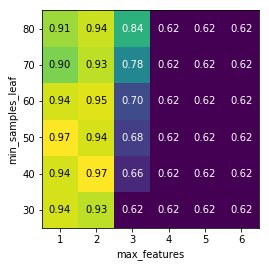

In [14]:
# based on the graph, there is no need to change hyper parameter test range
resultsRF = pd.DataFrame(grid_searchRF.cv_results_)
scoresRF = np.array(resultsRF.mean_test_score).reshape(6,6)
%matplotlib inline
heatmap(scoresRF, xlabel='max_features', xticklabels=param_gridRF['max_features'], ylabel='min_samples_leaf', yticklabels=param_gridRF['min_samples_leaf'], cmap="viridis")

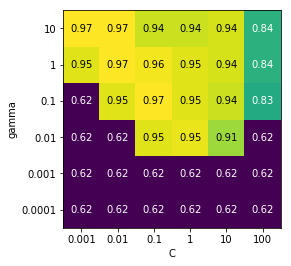

In [15]:
resultsSVC = pd.DataFrame(grid_searchSVC.cv_results_)
scoresSVC = np.array(resultsSVC.mean_test_score).reshape(6,6)
%matplotlib inline
heatmap(scoresSVC, xlabel='C', xticklabels=param_gridSVC['C'], ylabel='gamma', yticklabels=param_gridSVC['gamma'], cmap="viridis")

### Best_fit RF & SVC model

In [16]:
classifierRF = RandomForestClassifier(criterion = 'entropy', max_features = 4, min_samples_leaf = 3)
classifierSVC = SVC(C = 1, gamma = 0.001) 

### Accuracy and other prediction results

In [23]:

classifierRF_train = classifierRF.fit(X_train, y_train)
classifierSVC_train = classifierSVC.fit(X_train, y_train)

pred_RF_validset = classifierRF.predict(X_valid)
pred_SVC_validset = classifierRF.predict(X_valid)

confusionRF = confusion_matrix(y_valid, pred_RF_validset)
confusionSVC = confusion_matrix(y_valid, pred_SVC_validset)

print('Rf accuracy:', classifierRF.score(X_valid, y_valid))
print('SVC accuracy:', classifierSVC.score(X_valid, y_valid))
print(format(confusionRF))
print(format(confusionSVC))



Rf accuracy: 0.969465648855
SVC accuracy: 0.961832061069
[[86  3]
 [ 1 41]]
[[86  3]
 [ 1 41]]


In [24]:
ClassificationReport_RF = classification_report(y_valid, pred_RF_validset)
ClassificationReport_SVC = classification_report(y_valid, pred_SVC_validset)
print('RF : ', ClassificationReport_RF)
print('SVC : ', ClassificationReport_SVC)

RF :               precision    recall  f1-score   support

          2       0.99      0.97      0.98        89
          4       0.93      0.98      0.95        42

avg / total       0.97      0.97      0.97       131

SVC :               precision    recall  f1-score   support

          2       0.99      0.97      0.98        89
          4       0.93      0.98      0.95        42

avg / total       0.97      0.97      0.97       131



### Analysis of Classification Report

#### Based on the classification report, both RF and SVC models have same misprediction error. Thus, we need to see if there are out liers

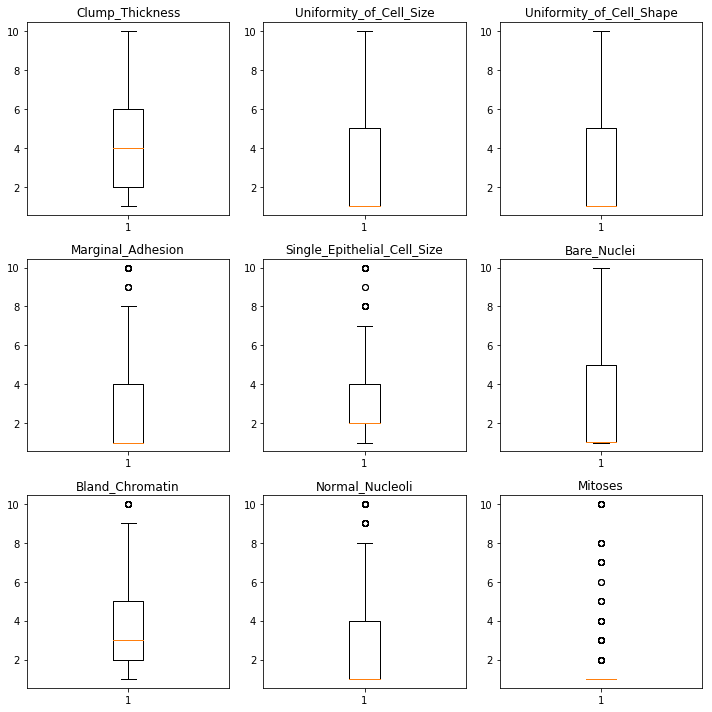

In [77]:
%matplotlib inline
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (10,10))
#fig = plt.figure(figsize = plt.figaspect(0.5))
names = [  'Clump_Thickness', 
           'Uniformity_of_Cell_Size',
           'Uniformity_of_Cell_Shape', 
           'Marginal_Adhesion',
           'Single_Epithelial_Cell_Size', 
           'Bare_Nuclei',
           'Bland_Chromatin',
           'Normal_Nucleoli',
           'Mitoses']
X_list = (X[:,0], X[:,1], X[:,2], X[:,3], X[:,4], X[:,5], X[:,6], X[:,7], X[:,8])
for ax, x, name in zip(axes.flat, X_list , names):
    ax.boxplot(x)
    ax.set(title=name)

plt.tight_layout()

In [85]:
Breast_cancer.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,4.416905,3.137536,3.210602,2.809456,3.217765,3.438395,2.869628,1.590258,2.690544
std,2.817673,3.052575,2.972867,2.856606,2.215408,2.440056,3.055004,1.716162,0.951596
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


### Outlier Analysis

#### It seems that outliers are consistent showing over all the variables. Thus, it might not be a good choice to get rid of all the 'out of quartile' data

In [87]:
classifierRF_train = classifierRF.fit(X_trainval, y_trainval)
classifierSVC_train = classifierSVC.fit(X_trainval, y_trainval)

pred_RF_testset = classifierRF.predict(X_test)
pred_SVC_testset = classifierRF.predict(X_test)

confusionRF = confusion_matrix(y_test, pred_RF_testset)
confusionSVC = confusion_matrix(y_test, pred_SVC_testset)

print('Rf accuracy:', classifierRF.score(X_test, y_test))
print('SVC accuracy:', classifierSVC.score(X_test, y_test))
print(format(confusionRF))
print(format(confusionSVC))

Rf accuracy: 0.96
SVC accuracy: 0.96
[[101   7]
 [  0  67]]
[[101   7]
 [  0  67]]


In [88]:
ClassificationReport_RF_testset = classification_report(y_test, pred_RF_testset)
ClassificationReport_SVC_testset = classification_report(y_test, pred_SVC_testset)
print('RF : ', ClassificationReport_RF_testset)
print('SVC : ', ClassificationReport_SVC_testset)

RF :               precision    recall  f1-score   support

          2       1.00      0.94      0.97       108
          4       0.91      1.00      0.95        67

avg / total       0.96      0.96      0.96       175

SVC :               precision    recall  f1-score   support

          2       1.00      0.94      0.97       108
          4       0.91      1.00      0.95        67

avg / total       0.96      0.96      0.96       175



## Result - Comparison between RF & SVC

#### They are accurate enough to be used in the real business field
Both SVC and RF seems to have similar accuracy and classification rate.
What need to be done is clarifying which data are outliers in the breast cancer data
Thus, futher understadning on the cells' characteristics are required
Overall, both method acquired 96 percent of accuracy rate. Further more, the false negative rate is extremely low, whcih means 
the model stays away from false negative diagnosis.